<a href="https://colab.research.google.com/github/dimoynwa/Computer-vision-tasks/blob/main/Grounding_DINO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment

Check `python` and `pip` versions.

Make sure GPU is available using `nvidia-smi` command. It should return anything, this indicates that `cuda` is available

In [ ]:
!python --version
!pip --version
!nvidia-smi

Python 3.10.12
pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
Sat Dec 28 14:56:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |   

Configure **HOME** directory.

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


Import pytorch and check pytorch and cuda versions.

In [ ]:
import torch

!nvcc --version
TORCH_VERSION = torch.__version__
CUDA_VERSION = torch.__version__.split('+')[-1]

print(f'Torch version: {TORCH_VERSION}')
print(f'CUDA version: {CUDA_VERSION}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Torch version: 2.5.1+cu121
CUDA version: cu121


## Install libraries

- Install `roboflow` for dataset
- Install `supervision` for labeling and annotationg images and videos
- Install `clearml` for experiment tracking

In [ ]:
!pip install roboflow supervision clearml

from IPython import display
display.clear_output()

import roboflow
print(f'Roboflow version: {roboflow.__version__}')

import supervision as sv
print(f'Supervision version: {sv.__version__}')

import clearml
print(f'ClearML version: {clearml.__version__}')

Roboflow version: 1.1.50
Supervision version: 0.25.1
ClearML version: 1.17.0


## Install Grounding DINO

Follow steps from official [GroundingDINO repository](https://github.com/IDEA-Research/GroundingDINO)

**Installation:**

1. Clone the GroundingDINO repository from [GitHub](https://github.com/IDEA-Research/GroundingDINO).
2. Change the current directory to the GroundingDINO folder.
3. Install the required dependencies in the current directory.

```pip install -e .```
4. Download pre-trained model weights.

```
mkdir weights
cd weights
wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
cd ..
```



In [ ]:
try:
  import groundingdino
except ImportError:
  !git clone https://github.com/IDEA-Research/GroundingDINO.git
  %cd GroundingDINO/
  !pip install -e .

from IPython import display
display.clear_output()

import groundingdino
print(f'Grounding DINO: {groundingdino}')

Grounding DINO: <module 'groundingdino' from '/content/GroundingDINO/GroundingDINO/groundingdino/__init__.py'>


### Download weights

In [ ]:
!mkdir weights
%cd weights
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
%cd ..

import os
print(f'Current working dir: {os.getcwd()}')

/content/GroundingDINO/GroundingDINO/weights
/content/GroundingDINO/GroundingDINO
Current working dir: /content/GroundingDINO/GroundingDINO


In [ ]:
WEIGHTS_DIR = os.path.join(HOME, 'GroundingDINO', 'GroundingDINO', 'weights')
assert os.path.exists(WEIGHTS_DIR)
print(f'Weights directory: {WEIGHTS_DIR}')

WEIGHTS_PATH = os.path.join(WEIGHTS_DIR, 'groundingdino_swint_ogc.pth')
assert os.path.exists(WEIGHTS_PATH)
print(f'Weights path: {WEIGHTS_PATH}')

Weights directory: /content/GroundingDINO/GroundingDINO/weights
Weights path: /content/GroundingDINO/GroundingDINO/weights/groundingdino_swint_ogc.pth


### Model Configuration path

In [ ]:
CONFIG_DIR = os.path.join(HOME, 'GroundingDINO', 'groundingdino', 'config')
assert os.path.exists(CONFIG_DIR)
print(f'Config directory: {CONFIG_DIR}')

CONFIG_PATH = os.path.join(CONFIG_DIR, 'GroundingDINO_SwinT_OGC.py')
assert os.path.exists(CONFIG_PATH)
print(f'Config path: {CONFIG_PATH}')

Config directory: /content/GroundingDINO/groundingdino/config
Config path: /content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py


## Download example images

Download some example image to experiment with

In [ ]:
%cd {HOME}
!mkdir {HOME}/data/
%cd {HOME}/data/

!wget -q https://sea.mastercard.com/content/dam/public/mastercardcom/sea/en/smb/cards/professional-credit-card_1280x720.png -O credit_card_1.png
!wget -q https://thestatebank.com/wp-content/uploads/2021/02/Interior-pages-images-Credit-Cards-400x600-1.png -O credit_card_2.png
!wget -q https://www.unclecu.org/wp-content/uploads/2022/01/Rewards_Card.png -O credit_card_3.png

assert os.path.exists(os.path.join(HOME, 'data', 'credit_card_1.png'))
assert os.path.exists(os.path.join(HOME, 'data', 'credit_card_2.png'))
assert os.path.exists(os.path.join(HOME, 'data', 'credit_card_3.png'))

/content
/content/data


## Load the Model


In [ ]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import load_model, load_image, predict
from groundingdino.util.inference import Model

model = Model(model_config_path=CONFIG_PATH, model_checkpoint_path=WEIGHTS_PATH)

/content/GroundingDINO


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## Inference

Detections(xyxy=array([[ 245.14249,  122.61113, 1037.0046 ,  611.6576 ],
       [ 329.26865,  280.62393,  436.1459 ,  378.62637]], dtype=float32), mask=None, confidence=array([0.48064154, 0.38328367], dtype=float32), class_id=None, tracker_id=None, data={}, metadata={})
['dog', 'dog']


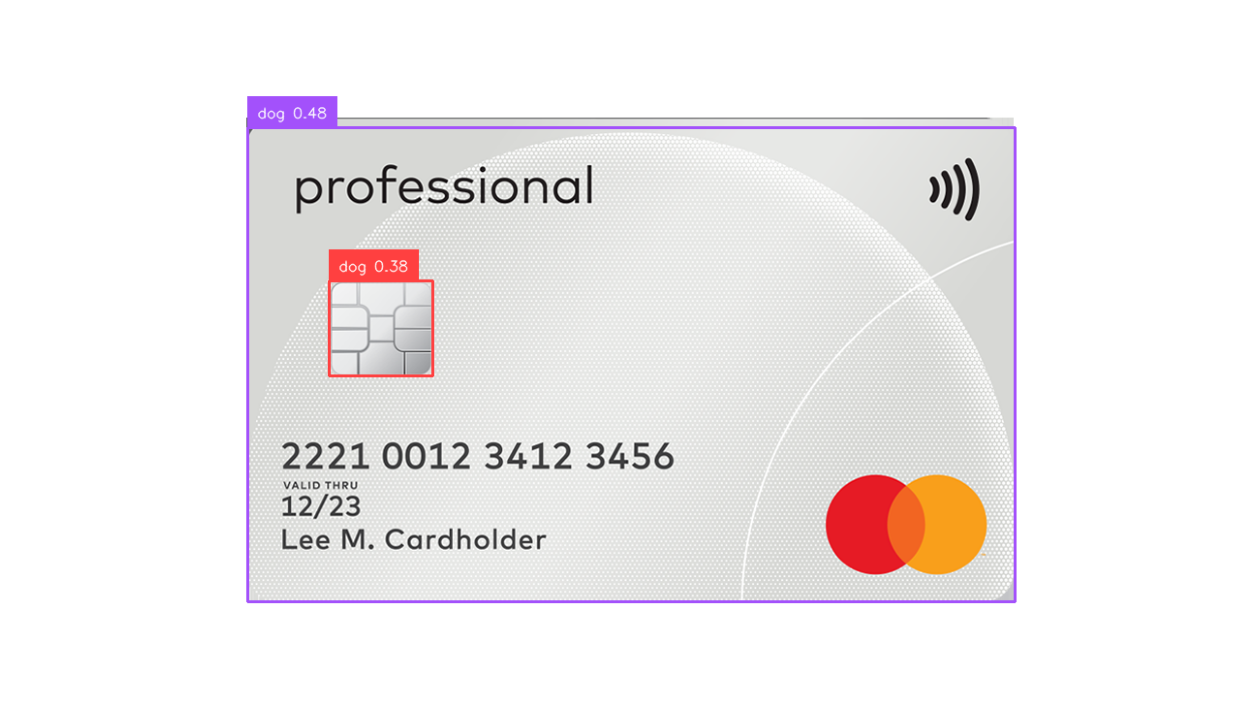

In [ ]:
import cv2
import supervision as sv
import os

SOURCE_IMAGE_PATH = os.path.join(HOME, 'data', 'credit_card_1.png')
assert os.path.exists(SOURCE_IMAGE_PATH)

CLASSES = ['dog']
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

caption = ', '.join(CLASSES)

image = cv2.imread(SOURCE_IMAGE_PATH)

# detections = model.predict_with_classes(image=image, classes=CLASSES, box_threshold=BOX_TRESHOLD, text_threshold=TEXT_TRESHOLD)

detections, labels = model.predict_with_caption(image=image, caption=caption, box_threshold=BOX_TRESHOLD, text_threshold=TEXT_TRESHOLD)

print(detections)
print(labels)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

labels = [
    f"{label} {confidence:0.2f}"
    for label, (_, _, confidence, class_id, _, _)
    in zip(labels, detections)]

annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, custom_color_lookup=sv.ColorLookup.INDEX)
annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels, custom_color_lookup=sv.ColorLookup.INDEX)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))